In [4]:
import json
from tangelo import SecondQuantizedMolecule
from tangelo.toolboxes.molecular_computation.integral_solver_pyscf import mol_to_pyscf, IntegralSolverPySCF
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo
from time import time
from tangelo.algorithms import VQESolver, CCSDSolver, FCISolver
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

In [5]:
def get_fractional_to_cartesian_matrix(a, b, c, alpha, beta, gamma,
                                       angle_in_degrees=True):
    if angle_in_degrees:
        # Convert angles to radians
        alpha = np.radians(alpha)
        beta = np.radians(beta)
        gamma = np.radians(gamma)
        
    lattice_a = np.array([a, 0, 0])
    lattice_b = np.array([b * np.cos(gamma), b * np.sin(gamma), 0])

    n2 = (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
    lattice_c = c * np.array([
        np.cos(beta),
        n2,
        np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)) / np.sin(gamma) 
    ])

    return np.array([lattice_a, lattice_b, lattice_c]).T

In [6]:
f = open('Li2FeSiO4.cif') # Li₂FeSiO₄
data = f.readlines()
data_lines = data[-16:]

def process(line):
    res = line.strip().split()
    atom = res[0][:-1]
    pos = [float(res[3]), float(res[4]), float(res[5])]

    if atom != 'Li':
        atom = atom[:-1]
    return (atom, pos)

res = list(map(process, data_lines))

symbols = [i[0] for i in res]
coords = [i[1] for i in res]

In [7]:
lattice_info = {}
for i in data[3:9]:
    res = i.strip().split()
    lattice_info[res[0].split('_')[-1]] = float(res[1])

lattice_info

{'a': 5.132302,
 'b': 11.037342,
 'c': 6.23237968,
 'alpha': 90.0,
 'beta': 91.30707992,
 'gamma': 90.0}

In [8]:
M = get_fractional_to_cartesian_matrix(*list(lattice_info.values()))
coords = (M @ (np.array(coords).T)).T

In [9]:
geometry = ""
for i, symbol in enumerate(symbols):
    geometry += f"{symbol} {coords[i][0]} {coords[i][1]} {coords[i][2]}\n"

In [10]:
class MyIntegralSolverPySCF(IntegralSolverPySCF):
    def compute_mean_field(self, sqmol):
        molecule = mol_to_pyscf(sqmol, sqmol.basis, sqmol.symmetry, sqmol.ecp)

        sqmol.mean_field = self.scf.RHF(molecule) if not sqmol.uhf else self.scf.UHF(molecule)
        sqmol.mean_field.verbose = 0
        sqmol.mean_field.conv_tol = 1e-5
        
        self.chkfile = 'mf_chkfile'
        sqmol.mean_field.chkfile = self.chkfile
        chkfile_found=True

        # Force broken symmetry for uhf calculation when spin is 0 as shown in
        # https://github.com/sunqm/pyscf/blob/master/examples/scf/32-break_spin_symm.py
        if sqmol.uhf and sqmol.spin == 0 and not chkfile_found:
            dm_alpha, dm_beta = sqmol.mean_field.get_init_guess()
            dm_beta[:1, :] = 0
            dm = (dm_alpha, dm_beta)
            sqmol.mean_field.kernel(dm)
        else:
            sqmol.mean_field.init_guess = "chkfile" if chkfile_found else "minao"
            sqmol.mean_field.kernel()

        sqmol.mean_field.analyze()
        if not sqmol.mean_field.converged:
            raise ValueError("Hartree-Fock calculation did not converge")

        if sqmol.symmetry:
            self.assign_mo_coeff_symmetries(sqmol)
        else:
            sqmol.mo_symm_ids = None
            sqmol.mo_symm_labels = None

        sqmol.mf_energy = sqmol.mean_field.e_tot
        sqmol.mo_energies = sqmol.mean_field.mo_energy
        sqmol.mo_occ = sqmol.mean_field.mo_occ

        sqmol.n_mos = molecule.nao_nr()
        sqmol.n_sos = 2*sqmol.n_mos

        self.mo_coeff = sqmol.mean_field.mo_coeff


class MySQMol(SecondQuantizedMolecule):    
    def __post_init__(self):
        self.solver = MyIntegralSolverPySCF()
        self.solver.set_physical_data(self)
        self.solver.compute_mean_field(self)
        self.freeze_mos(self.frozen_orbitals)

In [11]:
%%time
mol = MySQMol(geometry, q=0, spin=0, basis="sto3g", frozen_orbitals="frozen_core")

CPU times: user 15.2 s, sys: 3.25 s, total: 18.5 s
Wall time: 2.58 s


In [12]:
print(f"{mol.n_active_mos} active molecular orbitals")
print(f"{mol.n_active_electrons} active electrons")

92 active molecular orbitals
112 active electrons


In [21]:
qubit_reqs = []
num_terms = []

qu_ops = []

for level in range(1, 10):

    start = time()
    _frozen_orbitals = get_orbitals_excluding_homo_lumo(mol, homo_minus_n=level, lumo_plus_n=level)
    _frozen_mol = mol.freeze_mos(_frozen_orbitals, inplace=False)

    print(f"{_frozen_mol.n_active_mos} active molecular orbitals")
    print(f"{_frozen_mol.n_active_electrons} active electrons")
    
    qu_op = fermion_to_qubit_mapping(_frozen_mol.fermionic_hamiltonian, mapping="JW", 
                                 n_spinorbitals=_frozen_mol.n_active_sos, n_electrons=_frozen_mol.n_active_electrons, 
                                 spin=_frozen_mol.spin, up_then_down=False)

    qubit_reqs.append(count_qubits(qu_op))
    num_terms.append(len(qu_op.terms))
    qu_ops.append(qu_op)

    print(count_qubits(qu_op), num_terms[-1])
    del qu_op, _frozen_mol, _frozen_orbitals
    
    print(level, "Duration:", time() - start)

4 active molecular orbitals
4 active electrons
8 361
1 Duration: 13.445460796356201
6 active molecular orbitals
6 active electrons
12 1819
2 Duration: 13.691912174224854
8 active molecular orbitals
8 active electrons
16 5793
3 Duration: 15.373250722885132
10 active molecular orbitals
10 active electrons
20 14251
4 Duration: 19.341141939163208
12 active molecular orbitals
12 active electrons
24 29737
5 Duration: 39.64786171913147
14 active molecular orbitals
14 active electrons
28 55363
6 Duration: 77.60722613334656
16 active molecular orbitals
16 active electrons
32 94841
7 Duration: 110.084951877594
18 active molecular orbitals
18 active electrons
36 152415
8 Duration: 107.71771240234375
20 active molecular orbitals
20 active electrons
40 232949
9 Duration: 174.40698313713074


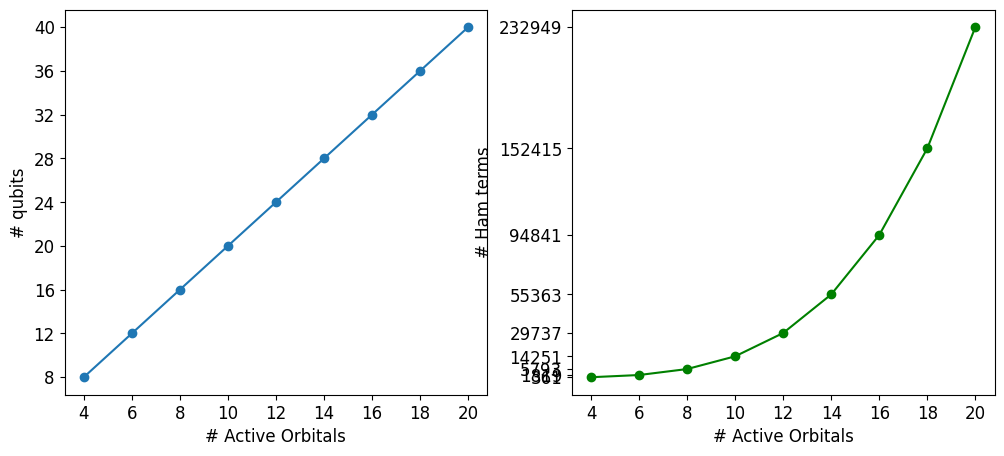

In [27]:
xticks = [4, 6, 8, 10, 12, 14, 16, 18, 20]
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(xticks, qubit_reqs, marker='o')
ax[0].set_xlabel('# Active Orbitals', fontsize=12)
ax[0].set_ylabel('# qubits', fontsize=12)
ax[0].set_xticks(xticks)
ax[0].set_yticks(qubit_reqs)
ax[0].set_xticklabels(xticks, fontsize=12)
ax[0].set_yticklabels(qubit_reqs, fontsize=12)

ax[1].plot(xticks, num_terms, marker='o', color='green')
ax[1].set_xlabel('# Active Orbitals', fontsize=12)
ax[1].set_ylabel('# Ham terms', fontsize=12)
ax[1].set_xticks(xticks)
ax[1].set_yticks(num_terms)
ax[1].set_xticklabels(xticks, fontsize=12)
ax[1].set_yticklabels(num_terms, fontsize=12);
plt.savefig('results/scaling.png', dpi=300)

In [29]:
hams_dict = {}

for i, level in enumerate(range(1,10)):
    coeffs = []
    term_list = []
    qu_op = qu_ops[i]
    n_qubits = count_qubits(qu_op)
    for term, coeff in qu_op.terms.items():
        coeffs.append(coeff.real)
        pauli_string = ['I']*n_qubits
        for i, p in term:
            pauli_string[i] = p
        pauli_string = ''.join(pauli_string)
        term_list.append(pauli_string)
    hams_dict[level] = {'coeffs':coeffs.copy(), 'terms': term_list.copy()}

In [30]:
with open('results/hams.pickle', 'wb') as handle:
    pickle.dump(hams_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
qubit_reqs = []
num_terms = []

qu_ops = []
energies = []
num_active_obs = []

t1s = []
t2s = []

for level in range(1, 25):

    _frozen_orbitals = get_orbitals_excluding_homo_lumo(mol, homo_minus_n=level, lumo_plus_n=level)
    _frozen_mol = mol.freeze_mos(_frozen_orbitals, inplace=False)

    print(f"{_frozen_mol.n_active_mos} active molecular orbitals")
    print(f"{_frozen_mol.n_active_electrons} active electrons")

    num_active_obs.append(_frozen_mol.n_active_mos)

    start = time()
    # fci_solver = FCISolver(_frozen_mol)
    # fci_energy = fci_solver.simulate()
    # print(f"{level} FCI Energy:", fci_energy)

    # energies.append(fci_energy)

    ccsd_solver = CCSDSolver(_frozen_mol)
    ccsd_energy = ccsd_solver.simulate()
    print(f"{level} CCSD Energy:", ccsd_energy)

    energies.append(ccsd_energy)
    
    t1s.append(ccsd_solver.solver.cc_fragment.t1)
    t2s.append(ccsd_solver.solver.cc_fragment.t2)
    
    print('-'*50)
    
    del _frozen_mol, _frozen_orbitals
    
    print(level, "Duration:", time() - start)

4 active molecular orbitals
4 active electrons
1 CCSD Energy: -3687.9345081094243
--------------------------------------------------
1 Duration: 1.352043867111206
6 active molecular orbitals
6 active electrons
2 CCSD Energy: -3687.936507061506
--------------------------------------------------
2 Duration: 1.370079755783081
8 active molecular orbitals
8 active electrons
3 CCSD Energy: -3688.046245761765
--------------------------------------------------
3 Duration: 2.2782657146453857
10 active molecular orbitals
10 active electrons
4 CCSD Energy: -3688.0553215284176
--------------------------------------------------
4 Duration: 2.4570960998535156
12 active molecular orbitals
12 active electrons
5 CCSD Energy: -3688.072406703199
--------------------------------------------------
5 Duration: 3.1005048751831055
14 active molecular orbitals
14 active electrons
6 CCSD Energy: -3688.1833559195675
--------------------------------------------------
6 Duration: 5.409244060516357
16 active molecu

In [55]:
dir(mol)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_active_space_integrals_uhf',
 '_get_fermionic_hamiltonian',
 '_get_molecular_hamiltonian_uhf',
 'active_mos',
 'active_occupied',
 'active_spin',
 'active_virtual',
 'basis',
 'coords',
 'ecp',
 'elements',
 'energy_from_rdms',
 'fermionic_hamiltonian',
 'freeze_mos',
 'frozen_mos',
 'frozen_occupied',
 'frozen_orbitals',
 'frozen_virtual',
 'get_active_space_integrals',
 'get_full_space_integrals',
 'get_integrals',
 'mean_field',
 'mf_energy',
 'mo_coeff',
 'mo_energies',
 'mo_occ',
 'mo_sym

In [52]:
amplitudes = [t1s, t2s]
with open('results/amplitudes.pickle', 'wb') as handle:
    pickle.dump(amplitudes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# ccsd_res = np.array([
#     num_active_obs,
#     energies
# ])

# with open('results/ccsd_res.npy', 'wb') as f:
#     np.save(f,ccsd_res)

In [20]:
# fci_res = [-3687.934503793257, -3687.9365130840906, -3688.0463027147557, -3688.05601403579, -3688.073128288608, -3688.1852283447315]
# norbs = [4, 6, 8,10, 12, 14]

# fci_res = np.array([
#     norbs,
#     fci_res
# ])

# with open('results/fci_res.npy', 'wb') as f:
#     np.save(f,fci_res)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

with open('results/ccsd_res.npy', 'rb') as f:
    ccsd_res = np.load(f)

with open('results/fci_res.npy', 'rb') as f:
    fci_res = np.load(f)

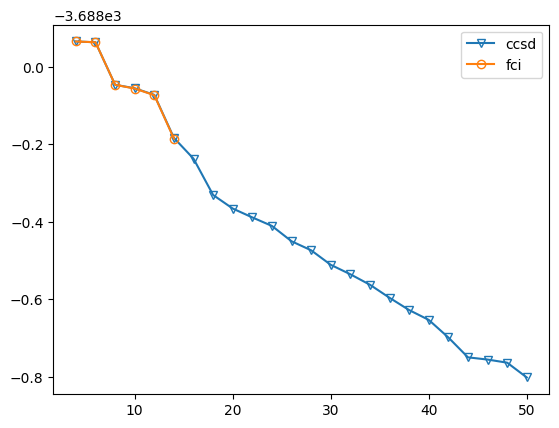

In [4]:
plt.plot(ccsd_res[0], ccsd_res[1], marker='v', label='ccsd', fillstyle='none')
plt.plot(fci_res[0], fci_res[1], marker='o', label='fci',fillstyle='none')
plt.legend()
plt.savefig('results/classical.png', dpi=300)